In [1]:
import warnings
warnings.filterwarnings('ignore')
from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model


In [2]:
dataset = r"Data/"

In [3]:
INIT_LR = 1e-3
EPOCHS = 10
BATCH_SIZE = 8
args = {}
args['dataset'] =dataset

In [4]:
import  numpy as np
import cv2
import os

ip_Paths = list(paths.list_images(args['dataset']))

data = []
labels = []

for i in ip_Paths:
    label = i.split(os.path.sep)[-2]
    image = cv2.imread(i)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    data.append(image)
    labels.append(label)

data = np.array(data)/255.0

In [5]:
Cimages = os.listdir(dataset+"Covid")
Nimages = os.listdir(dataset+"Normal")

Normal Chest X-ray Vs Covid-19 Chest X-ray


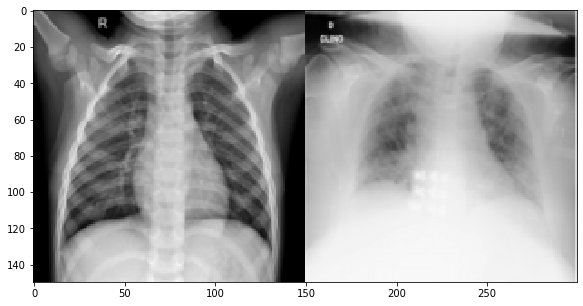

Normal Chest X-ray Vs Covid-19 Chest X-ray


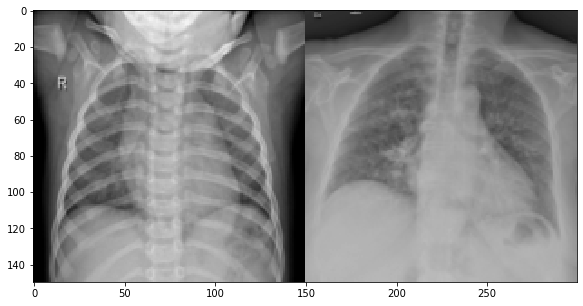

Normal Chest X-ray Vs Covid-19 Chest X-ray


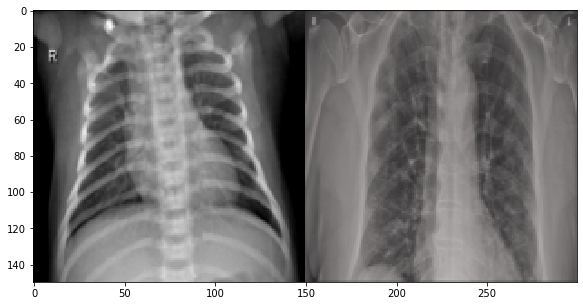

Normal Chest X-ray Vs Covid-19 Chest X-ray


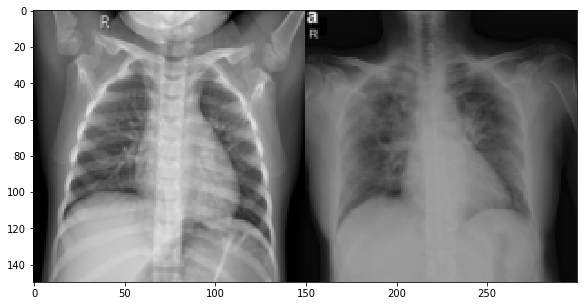

Normal Chest X-ray Vs Covid-19 Chest X-ray


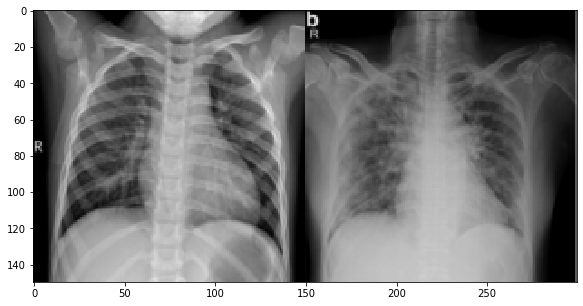

In [6]:
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.transform import resize
import numpy as np
def plotter(i):
    normal = cv2.imread(dataset+"Normal//"+Nimages[i])
    normal = skimage.transform.resize(normal, (150, 150, 3))
    coronavirus = cv2.imread(dataset+"Covid//"+Cimages[i])
    coronavirus = skimage.transform.resize(coronavirus, (150, 150, 3) , mode = 'reflect')
    pair = np.concatenate((normal, coronavirus), axis=1)
    print("Normal Chest X-ray Vs Covid-19 Chest X-ray")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

In [7]:
LB = LabelBinarizer()
labels =LB.fit_transform(labels)
labels = to_categorical(labels)


In [8]:
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.2,random_state=42,
                                                stratify=labels)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(160, 224, 224, 3) (40, 224, 224, 3) (160, 2) (40, 2)


In [9]:
trainAug = ImageDataGenerator(rotation_range=15,fill_mode='nearest')
trainAug

In [10]:
baseModel = VGG16(weights ='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
model = baseModel.output
model = MaxPooling2D(pool_size=(4,4))(model)
model = Flatten(name='flatten')(model)
model = Dense(64,activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(2,activation='softmax')(model)

model = Model(baseModel.input,model)
for layer in baseModel.layers:
    layer.trainable=False
    

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

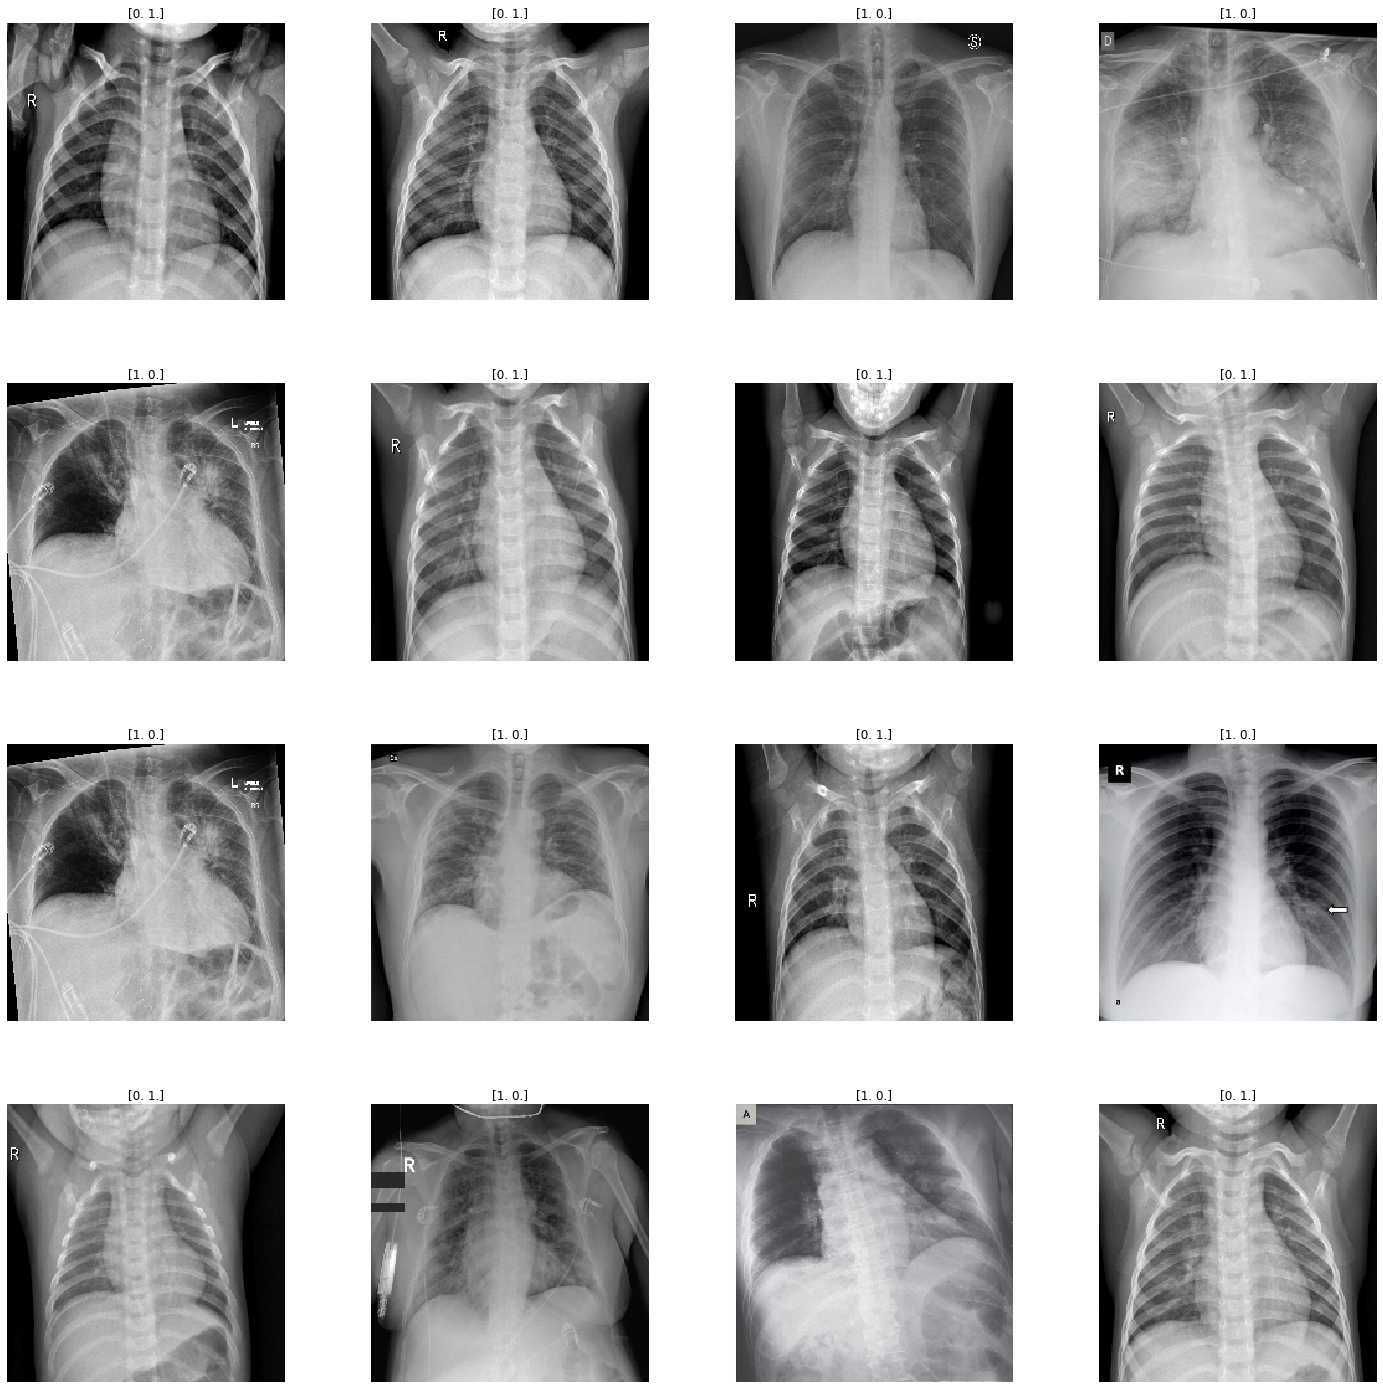

In [14]:
W_grid = 4 #width
L_grid = 4 #length
fig, axes = plt.subplots(L_grid, W_grid, figsize = (25, 25)) #subplots
axes = axes.ravel()
n_training = len(X_train)
for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(X_train[index])
    axes[i].set_title(y_train[index])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.3)

In [15]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Compiling Starts")
R = model.fit_generator(
    trainAug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BATCH_SIZE,
    epochs=EPOCHS)

Compiling Starts
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
20/20 [==============================] - 95s 5s/step - loss: 0.7393 - acc: 0.5750 - val_loss: 0.4363 - val_acc: 0.9500
Epoch 2/10
20/20 [==============================] - 93s 5s/step - loss: 0.4396 - acc: 0.8313 - val_loss: 0.2746 - val_acc: 0.9750
Epoch 3/10
20/20 [==============================] - 94s 5s/step - loss: 0.2608 - acc: 0.9312 - val_loss: 0.2018 - val_acc: 0.9750
Epoch 4/10
20/20 [==============================] - 95s 5s/step - loss: 0.1834 - acc: 0.9625 - val_loss: 0.1591 - val_acc: 0.9750
Epoch 5/10
20/20 [==============================] - 94s 5s/step - loss: 0.1568 - acc: 0.9688 - val_loss: 0.1099 - val_acc: 1.0000
Epoch 6/10
20/20 [==============================] - 94s 5s/step - loss: 0.1329 - acc: 0.9750 - val_loss: 0.0910 - val_acc: 0.9750
Epoch 7/10
20/20 [==============================] - 97s 5s/step - loss: 0.0962 - acc: 0.9812 - val_loss: 0.06

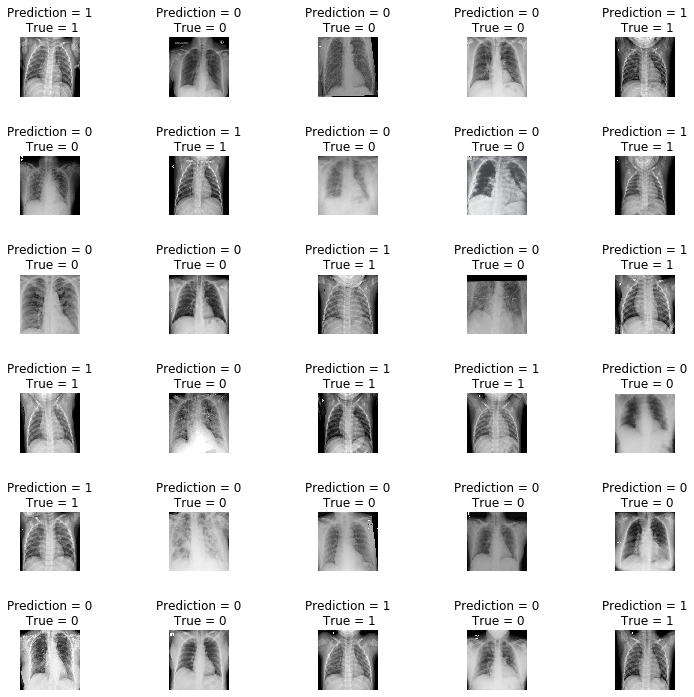

In [16]:
L = 6
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred.argmax(axis=1)[i], y_test.argmax(axis=1)[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1)   

In [17]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test,batch_size=BATCH_SIZE)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test.argmax(axis=1),y_pred,target_names=LB.classes_))

              precision    recall  f1-score   support

  Data/Covid       1.00      1.00      1.00        20
 Data/Normal       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.argmax(axis=1),y_pred)

1.0

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[20  0]
 [ 0 20]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


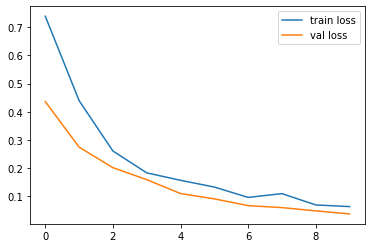

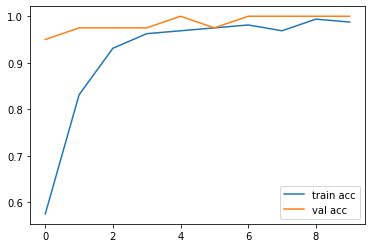

In [23]:
# plot the loss
plt.plot(R.history['loss'], label='train loss')
plt.plot(R.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(R.history['acc'], label='train acc')
plt.plot(R.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [24]:
model.save('Covid_model.h5')

### Prediction on Test Data

Using TensorFlow backend.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Prediction: Corona


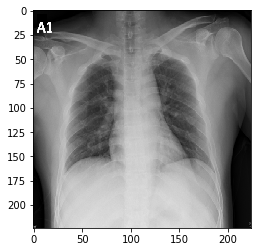

In [25]:
import tensorflow as tf 
from keras.preprocessing import image
#from keras.models import load_model
model = tf.keras.models.load_model('Covid_model.h5')
from keras.applications.vgg16 import preprocess_input
img = image.load_img('Data/Covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png', target_size=(224, 224)) #insert a random covid-19 x-ray image
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
    print('Prediction: Normal')
else:
    print('Prediction: Corona')

Prediction: Normal


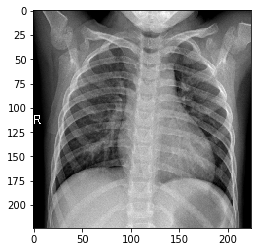

In [27]:
img = image.load_img('Data/Normal/IM-0162-0001.jpeg', target_size=(224, 224)) #insert a random normal x-ray image
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
    print('Prediction: Normal')
else:
    print('Prediction: Corona')